# Shape optimization of a tensile specimen

In [17]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from torchfem.io import import_mesh

## Import reference model
This imports the reference model, sets up boundary conditions and computes the intial stresses prior to optimization.

In [18]:
# Material model (plane stress)
E = 72000.0
nu = 0.2
fac = E / (1.0 - nu**2)
C = fac * torch.tensor([[1.0, nu, 0.0], [nu, 1.0, 0.0], [0.0, 0.0, 0.5 * (1.0 - nu)]])

# Import mesh
specimen = import_mesh("../meshes/tensile.vtu", C=C)

# Left end BCs (fixed)
left = specimen.nodes[:, 0] < 0.1
specimen.constraints[left, 0] = True
specimen.constraints[left & (torch.abs(specimen.nodes[:, 1]) < 0.1), 1] = True

# right end BCs (prescribed displacement)
right = specimen.nodes[:, 0] >= 149.9
specimen.constraints[right, 0] = True
specimen.displacements[right, 0] = 1.0

Maximum v.Mises stress is 606.59.


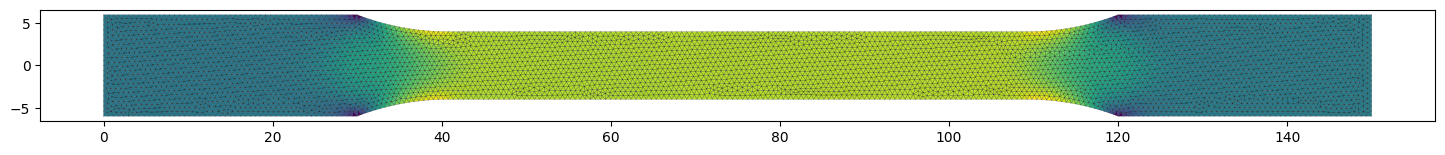

In [19]:
u, _ = specimen.solve()
mises = specimen.compute_stress(u, mises=True)
specimen.plot(axes=True, bcs=False, element_property=mises, linewidth=0.1, figsize=(18,3))
print(f"Maximum v.Mises stress is {torch.max(mises):.2f}.")

## Mesh morphing with radial basis functions
The `morph` function applies a shape change to a region of the mesh. It uses radial basis functions to regularize the shape change.

In [20]:
# Radial basis function
r = torch.cdist(specimen.nodes, specimen.nodes)
epsilon = 0.4
phi = torch.exp(-((epsilon * r) ** 2))

def morph(fem, nids, x, dir):
    # Build matrix
    M = phi[:, nids]
    M = M[nids, :]
    # Solve linear equation system
    weights = torch.linalg.solve(M, x - fem.nodes[nids, dir])
    # Apply deformation
    fem.nodes[:, dir] += weights @ phi[nids, :]

## Shape optimization

The objective function $f$ uses a set of control nodes to morph the mesh and compute the resulting top N stresses. It returns the average top v. Mises stresses, which should be mimized. The top N stresses are chosen to regularize the problem, if only the maximum would be chosen, the responsible maximum stressed element might jump from iteration to iteration.

In [21]:
control_nodes = [137, 142, 264, 269, 403, 408, 530, 535]


def f(x):
    # Detach previous gradients
    specimen.nodes = specimen.nodes.detach()
    # Update nodes
    morph(specimen, control_nodes, x, 1)
    # Solve fem with updated nodes
    u, _ = specimen.solve()
    # Compute stress
    mises = specimen.compute_stress(u, mises=True)
    # Compute average of top stresses
    N = 20
    top_stresses = torch.topk(mises, N)[0]
    top_stress_avg = top_stresses.sum() / N
    # Return average of top stresses
    return top_stress_avg

In [22]:
# Initial values (= current y node positions)
x = torch.tensor(specimen.nodes[control_nodes, 1].numpy(), requires_grad=True)
# Optimizer settings
optimizer = torch.optim.Adam([x], lr=0.04)
# Variable to store intermediate values
stresses = []

for _ in tqdm(range(20)):
    optimizer.zero_grad()
    objective = f(x)
    stresses.append(objective.detach().item())
    objective.backward()
    optimizer.step()

100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


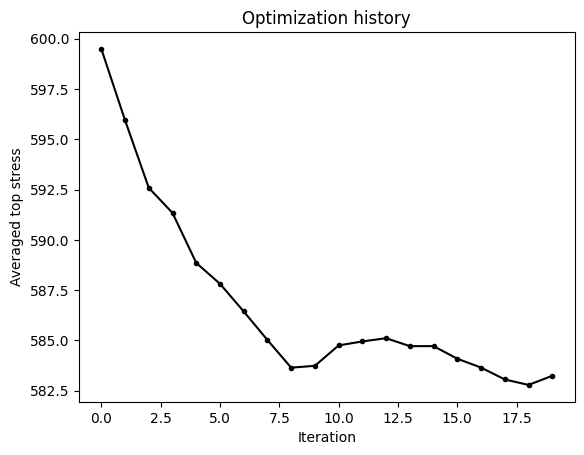

In [23]:
plt.plot(stresses, ".-k")
plt.title("Optimization history")
plt.xlabel("Iteration")
plt.ylabel("Averaged top stress")
plt.show()

Maximum v.Mises stress is 589.71.


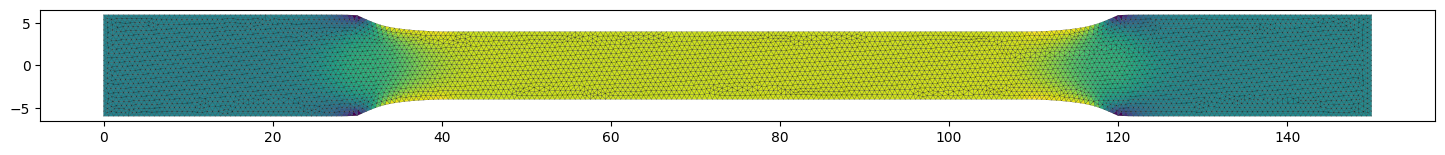

In [24]:
u, _ = specimen.solve()
mises = specimen.compute_stress(u, mises=True)
specimen.plot(axes=True, bcs=False, element_property=mises, linewidth=0.1, figsize=(18,3))
print(f"Maximum v.Mises stress is {torch.max(mises):.2f}.")